In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable


In [3]:
batch_size = 64
learning_rate = 3e-3
num_epochs = 30


In [4]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}

data_sets = {
    'train': torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.CIFAR100(root='./data', download=True, transform=data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}


Files already downloaded and verified
Files already downloaded and verified


In [5]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [6]:
import random


class PermuteAdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, p=0.01, eps=1e-5):
        super(PermuteAdaptiveInstanceNorm2d, self).__init__()
        self.p = p
        self.eps = eps

    def forward(self, x):
        permute = random.random() < self.p
        if permute and self.training:
            perm_indices = torch.randperm(x.size()[0])
        else:
            return x
        size = x.size()
        N, C, H, W = size
        if (H, W) == (1, 1):
            
            return x
        return adaptive_instance_normalization(x, x[perm_indices], self.eps)

    def extra_repr(self) -> str:
        return 'p={}'.format(
            self.p
        )


def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C, H, W = size
    feat_std = torch.sqrt(feat.view(N, C, -1).var(dim=2).view(N, C, 1, 1) + eps)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adaptive_instance_normalization(content_feat, style_feat, eps=1e-5):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat.detach(), eps)
    content_mean, content_std = calc_mean_std(content_feat, eps)
    content_std = content_std + eps  # to avoid division by 0
    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

In [7]:

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
   
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
       
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output



def resnet50():
    
    return ResNet(BottleNeck, [3, 4, 6, 3])


In [8]:
model = resnet50()

model = model.cuda() if use_cuda else model
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [9]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
  
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])
        
        if phase == 'train':
            train_acces.append(epoch_acc)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc)
            test_losses.append(epoch_loss)
            
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')
    

Epoch 0


train-loss: 0.0670, train-acc: 0.0406
test loss: 0.0608, test acc: 0.0900

Epoch 1


train-loss: 0.0630, train-acc: 0.1021
test loss: 0.0569, test acc: 0.1692

Epoch 2


train-loss: 0.0594, train-acc: 0.1774
test loss: 0.0530, test acc: 0.2644

Epoch 3


train-loss: 0.0560, train-acc: 0.2482
test loss: 0.0507, test acc: 0.2962

Epoch 4


train-loss: 0.0528, train-acc: 0.3201
test loss: 0.0475, test acc: 0.3941

Epoch 5


train-loss: 0.0500, train-acc: 0.3797
test loss: 0.0447, test acc: 0.4540

Epoch 6


train-loss: 0.0474, train-acc: 0.4286
test loss: 0.0421, test acc: 0.5210

Epoch 7


train-loss: 0.0452, train-acc: 0.4769
test loss: 0.0397, test acc: 0.5719

Epoch 8


train-loss: 0.0431, train-acc: 0.5141
test loss: 0.0378, test acc: 0.5855

Epoch 9


train-loss: 0.0413, train-acc: 0.5514
test loss: 0.0360, test acc: 0.6210

Epoch 10


train-loss: 0.0390, train-acc: 0.6838
test loss: 0.0338, test acc: 0.7827

Epoch 11


train-loss: 0.0369, train-acc: 0.7330
test loss: 0.03

In [10]:
train_acces = [t.cpu().numpy() for t in train_acces]
test_acces = [t.cpu().numpy() for t in test_acces]


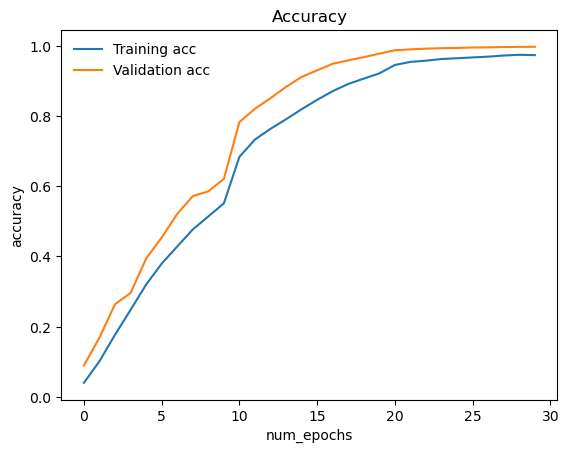

In [11]:
plt.title("Accuracy")
plt.plot(train_acces, label='Training acc')
plt.plot(test_acces, label='Validation acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)


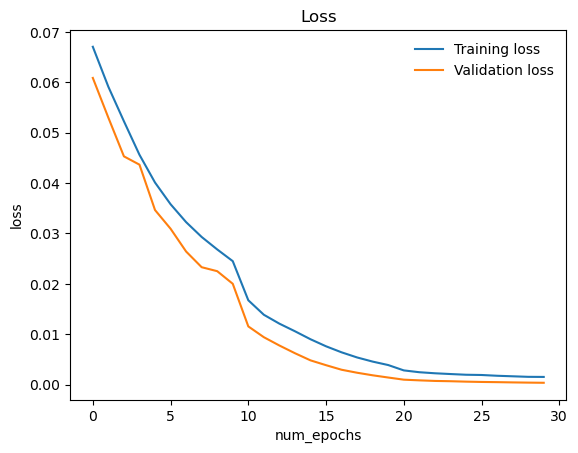

In [12]:
plt.title("Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()


In [13]:
train_acces

[array(0.04058),
 array(0.10206),
 array(0.17738),
 array(0.24822),
 array(0.3201),
 array(0.3797),
 array(0.42856),
 array(0.47692),
 array(0.51408),
 array(0.55142),
 array(0.68382),
 array(0.73302),
 array(0.76336),
 array(0.79058),
 array(0.81926),
 array(0.84586),
 array(0.87062),
 array(0.89112),
 array(0.90624),
 array(0.92126),
 array(0.9451),
 array(0.95396),
 array(0.95726),
 array(0.9621),
 array(0.9642),
 array(0.96654),
 array(0.96876),
 array(0.97202),
 array(0.97406),
 array(0.97314)]

In [14]:
test_acces

[array(0.09),
 array(0.16924),
 array(0.26436),
 array(0.2962),
 array(0.39408),
 array(0.454),
 array(0.521),
 array(0.57188),
 array(0.58554),
 array(0.62104),
 array(0.7827),
 array(0.82056),
 array(0.85058),
 array(0.88282),
 array(0.91118),
 array(0.92982),
 array(0.94858),
 array(0.95814),
 array(0.96744),
 array(0.97732),
 array(0.98698),
 array(0.98954),
 array(0.99154),
 array(0.99286),
 array(0.99358),
 array(0.99484),
 array(0.9953),
 array(0.99604),
 array(0.9966),
 array(0.99686)]

In [15]:
train_losses

[0.06701605142116547,
 0.05907597359657288,
 0.052241477365493776,
 0.04559064733028412,
 0.04008478799104691,
 0.035786060819625855,
 0.032229885103702546,
 0.02928792004585266,
 0.026813509533405305,
 0.024489590659141542,
 0.016730377756357193,
 0.013853961751461029,
 0.012089211064577103,
 0.010582503341436386,
 0.00899859841644764,
 0.007598475395143032,
 0.006402878630459309,
 0.005383210855871439,
 0.0045621278496086595,
 0.003878075580894947,
 0.0028177340368926527,
 0.0024568303078413008,
 0.002248503575176001,
 0.002096927428841591,
 0.001956252461820841,
 0.001908053701557219,
 0.0017540557213127613,
 0.001649324008524418,
 0.0015421755191870033,
 0.0015226566345244647]

In [16]:
test_losses

[0.06083732135772705,
 0.05294654296875,
 0.04527960985660553,
 0.04363037495136261,
 0.03462939647436142,
 0.03092326669931412,
 0.026399321916103363,
 0.02328913964509964,
 0.022500196452140808,
 0.020000741963386536,
 0.011545568733215331,
 0.009403185057640076,
 0.007754737497866154,
 0.006225866028368473,
 0.004808362691700458,
 0.0038515432345867157,
 0.0029465824577957394,
 0.0023529694098234177,
 0.0018452755672484636,
 0.0014043573062121869,
 0.0009791573108360171,
 0.0008432697119377554,
 0.0007289850553125143,
 0.0006714259705878794,
 0.000588376570418477,
 0.0005268299455475062,
 0.0004877497227024287,
 0.0004369196159392595,
 0.0003949834241438657,
 0.00036215041532181204]